In [7]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets as D
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import DisjointSet
import random

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Loading the Dataset

In [2]:
# the total nr of points inside the sample dataset
N_SAMPLES = 1500

noisy_circles = D.make_circles(n_samples=N_SAMPLES, factor=.5, noise=.05)
noisy_circles

(array([[-0.96030032, -0.15368602],
        [ 0.51487758,  0.82215873],
        [ 0.3846991 ,  0.31543015],
        ...,
        [ 0.34277664,  0.40481   ],
        [ 0.02341956, -0.4432913 ],
        [-0.13958856, -0.46846947]]),
 array([0, 0, 1, ..., 1, 1, 1], dtype=int64))

In [3]:
def sklearn_scatter_to_df(sklearn_scatter_data):
    return pd.DataFrame(data={
        'x': [sklearn_scatter_data[0][i][0] for i in range(len(sklearn_scatter_data[0]))],
        'y': [sklearn_scatter_data[0][i][1] for i in range(len(sklearn_scatter_data[0]))],
        'cluster': [sklearn_scatter_data[1][i] for i in range(len(sklearn_scatter_data[0]))]
    })

<Axes: xlabel='x', ylabel='y'>

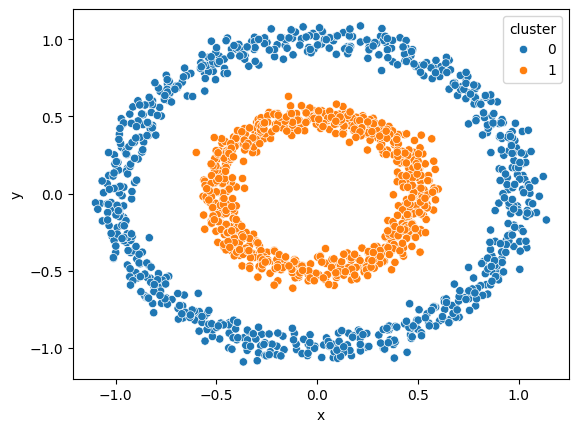

In [4]:
sns.scatterplot(sklearn_scatter_to_df(noisy_circles), x='x', y='y', hue='cluster')

# The MST Algorithm

In [5]:
# Is this needed?

class UndirectedWeightedGraph:
    def __init__(self, edge_weights, vertices):
        self.__edge_weights = edge_weights
        self.__vertices = vertices

    def n_edges(self):
        result = 0
        for v in self.edge_weights:
            result += len(self.edge_weights.keys())

        return result
        
    def vertices(self):
        return self.__vertices
        
    def weight(self, v1, v2):
        if v1 < v2 and v1 in self.__edge_weights and v2 in self.__edge_weights[v1]:
            return self.__edge_weights[v1][v2]
        elif v2 < v1 and v2 in self.__edge_weights and v1 in self.__edge_weights[v2]:
            return self.__edge_weights[v2][v1]
        else:
            return math.inf
        
    def neighbourhood(self, vertex):
        n = []
        
        if vertex in self.__edge_weights.keys():
            for v in self.__edge_weights[vertex].keys():
                n.append((v, self.__edge_weights[vertex][v]))

        for v in range(vertex):
            if v in self.__edge_weights.keys() and vertex in self.__edge_weights[v].keys():
                n.append((v, self.__edge_weights[v][vertex]))
                
        return n

# Version not using PySpark

In [42]:
class Edge:
    def __init__(self, x, y, w):
        self.x = x
        self.y = y
        self.w = w

    def __repr__(self):
        return '{{({}, {}), w:{}}}'.format(self.x, self.y, self.w)

In [48]:
def MSTKruskal(edges):
    result = []
    
    disjoint_set = DisjointSet()
    edges.sort(key=lambda e: e.w)

    for edge in edges:
        disjoint_set.add(edge.x)
        disjoint_set.add(edge.y)
        
        if not disjoint_set.connected(edge.x, edge.y):
            disjoint_set.merge(edge.x, edge.y)
            result.append(edge)

    return result

In [49]:
edges = [Edge(1, 2, 2), Edge(1, 7, 8), Edge(2, 3, 1), Edge(3, 7, 7)]
MSTKruskal(edges)

[{(2, 3), w:1}, {(1, 2), w:2}, {(3, 7), w:7}]